# Gene Expression Analysis

In [1]:
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from scipy.stats import ttest_rel
from tqdm import tqdm

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
)

In [ ]:
# Initial Files
cluster_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.json"
network_file_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_network.positive.tsv"
go_map_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_GO_map.csv"

GO_DB = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/go.obo"

# Gene Expression Data
expression_file_path = "/mnt/home/ssledzieski/database/philharmonic/p_damicornis/Connelly2022_AxH_Pdam.counts"
deg_file_path = "/mnt/home/ssledzieski/database/philharmonic/p_damicornis/Connelly2022_SupplementaryData.xlsx"

# Output paths
prot_deg_cytoscape_table = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_proteins.deg.tsv"
clust_deg_cytoscape_table = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.deg.tsv"

IMG_DIR = Path("/mnt/home/ssledzieski/Projects/philharmonic-experiments/img/pdam")

---

## Load Files

In [9]:
cluster_dict = load_cluster_json(cluster_file_path)
go_database = parse_GO_database(GO_DB)
full_G = nx.read_weighted_edgelist(network_file_path, delimiter="\t")

In [52]:
deg_df = pd.read_excel(
    deg_file_path,
    sheet_name="Table_S4A_DEGs_coral",
    header=1,
    index_col=0,
).rename(
    {
        "DE_Heat": "DE_Heat_control",
        "DE_Antibiotics": "DE_Antibiotics_control",
        "DE_Antibiotics.Heat": "DE_Antibiotics.Heat_control",
    },
    axis=1,
)
deg_df.index = deg_df.index + "-RA"

In [53]:
expression_df = pd.read_csv(expression_file_path, sep="\t", skiprows=1)
expression_df.columns = [i.split("/")[-1].split("_")[0] for i in expression_df.columns]
expression_df["Geneid"] = expression_df["Geneid"] + "-RA"
expression_df = expression_df.set_index("Geneid")
expression_df = expression_df.iloc[:, 5:]

---

## Raw Expression

In [54]:
philharmonic_proteins = set.union(
    *[
        set(i["members"] + list(i["recipe"]["degree"]["0.75"]))
        for i in cluster_dict.values()
    ]
)
expression_philharmonic = expression_df.loc[
    expression_df.index.intersection(philharmonic_proteins)
]

In [55]:
logger.info(f"Expression data has shape: {expression_philharmonic.shape}")
expression_philharmonic.head()

2025-05-06 09:33:10.401 | INFO     | __main__:<module>:1 - Expression data has shape: (7242, 47)


,Hw1-1a,Hw1-1b,Hw1-1c,Hw1-4a,Hw1-4b,Hw1-4c,Hw1-5a,Hw1-5b,Hw1-5c,Hw1-6a,...,Wt2-1c,Wt2-4a,Wt2-4b,Wt2-4c,Wt2-5a,Wt2-5b,Wt2-5c,Wt2-6a,Wt2-6b,Wt2-6c
Geneid,,,,,,,,,,,,,,,,,,,,,
pdam_00021773-RA,292,72,77,26,8,37,353,51,271,380,...,6,5,34,16,30,23,2,28,13,25
pdam_00022011-RA,1,10,6,8,15,7,17,27,10,18,...,17,23,74,101,47,31,39,67,74,79
pdam_00012251-RA,925,1950,1260,624,1104,1154,2973,1975,1960,2170,...,1215,1117,1905,1670,1574,1933,1502,1813,1460,1686
pdam_00012254-RA,110,278,197,159,164,253,362,523,424,356,...,370,334,618,514,577,550,353,715,347,502
pdam_00012261-RA,5,7,26,30,26,14,68,103,50,46,...,104,30,188,279,156,203,100,273,246,185


Following Connelly et al., we apply a variance-stabilizing transformation to expression counts, then compute the pairwise bi-weighted mid-correlation between genes.

In [56]:
def vst(counts, alpha=1):
    """
    Apply a variance stabilizing transformation to count data.

    Parameters:
    counts (array-like): The input count data
    alpha (float): A small constant to avoid taking log of zero

    Returns:
    numpy.ndarray: The transformed data
    """
    counts = np.asarray(counts)
    return np.log2(counts + np.sqrt(counts + alpha**2))


def bicor_matrix(X, epsilon=1e-12):
    """
    Compute pairwise bi-weight mid-correlation for all genes.

    Parameters:
    X (np.ndarray): A 2D array of shape (n_genes, n_samples) containing normalized count data
    epsilon (float): Small value to avoid division by zero

    Returns:
    np.ndarray: A 2D array of shape (n_genes, n_genes) containing pairwise correlations
    """
    # Compute median and MAD for each gene
    gene_medians = np.median(X, axis=1)
    gene_mads = np.median(np.abs(X - gene_medians[:, np.newaxis]), axis=1)

    # Handle genes with zero MAD
    gene_mads = np.maximum(gene_mads, epsilon)

    # Compute U matrix
    U = (X - gene_medians[:, np.newaxis]) / (9 * gene_mads[:, np.newaxis])

    # Compute weights
    W = (1 - U**2) ** 2
    W[np.abs(U) >= 1] = 0

    # Compute weighted centered expression
    X_weighted = W * (X - gene_medians[:, np.newaxis])

    # Compute pairwise correlations
    norms = np.sqrt(np.sum(X_weighted**2, axis=1))
    norms = np.maximum(norms, epsilon)  # Avoid division by zero
    corr_matrix = np.dot(X_weighted, X_weighted.T) / np.outer(norms, norms)

    # Set diagonal to 1 and handle numerical instability
    np.fill_diagonal(corr_matrix, 1)
    corr_matrix = np.clip(corr_matrix, -1, 1)

    return corr_matrix

In [57]:
dense_df = expression_df[
    np.sum(expression_df > 0, axis=1) > expression_df.shape[1] * 0.5
]
dense_corr = bicor_matrix(vst(dense_df.values))
dense_corr_df = pd.DataFrame(
    dense_corr,
    index=dense_df.index,
    columns=dense_df.index,
)
logger.info(f"Expression data has shape: {expression_df.shape}")
logger.info(f"Dense correlation matrix has shape: {dense_corr_df.shape}")
logger.info(f"Dense correlation matrix has {np.sum(np.isnan(dense_corr))} NaN values")

2025-05-06 09:33:16.096 | INFO     | __main__:<module>:10 - Expression data has shape: (26077, 47)
2025-05-06 09:33:16.098 | INFO     | __main__:<module>:11 - Dense correlation matrix has shape: (20496, 20496)
2025-05-06 09:33:16.656 | INFO     | __main__:<module>:12 - Dense correlation matrix has 0 NaN values


In [58]:
cluster_proteins = set.union(*[set(i["members"]) for i in cluster_dict.values()])
removed_proteins = set(expression_df.index).difference(dense_corr_df.index)
removed_cluster_proteins = cluster_proteins.intersection(removed_proteins)
logger.info(
    f"Removed {len(removed_proteins)} proteins from the expression data because of sparsity, {len(removed_cluster_proteins)} which were in clusters."
)

2025-05-06 09:33:18.614 | INFO     | __main__:<module>:4 - Removed 5581 proteins from the expression data because of sparsity, 796 which were in clusters.


In [59]:
def extract_cluster_correlations(
    cluster_members, correlation_df, summary_func=None, dataframe=False
):
    """
    Extract the lower diagonal of pairwise correlations for a set of genes.

    Parameters:
    cluster_members (list): A list of gene names
    correlation_df (pd.DataFrame): A DataFrame containing pairwise correlations

    Returns:
    pd.DataFrame: A DataFrame containing pairwise correlations for the input genes
    """
    members = list(set(cluster_members).intersection(correlation_df.index))
    cluster_correlations = correlation_df.loc[members, members].values[
        np.tril_indices(len(members), k=-1)
    ]
    if summary_func:
        return summary_func(cluster_correlations)
    elif dataframe:
        return correlation_df.loc[members, members]
    else:
        return cluster_correlations


def resample_correlation_matrix(correlation_df, random_seed=42):
    """
    Randomly re-order the row and column names and reassign them to a correlation matrix.
    """
    from copy import deepcopy

    new_df = deepcopy(correlation_df)
    rng = np.random.default_rng(random_seed)
    new_prot_order = rng.permutation(new_df.index)
    new_df.index = new_prot_order
    new_df.columns = new_prot_order
    return new_df

In [60]:
rand_correlation_df = resample_correlation_matrix(dense_corr_df)

cluster_corr_df = pd.DataFrame(
    {
        "key": cluster_dict.keys(),
        "True": [
            extract_cluster_correlations(
                c["members"] + list(c["recipe"]["degree"]["0.75"]),
                dense_corr_df,
                np.median,
            )
            for c in tqdm(cluster_dict.values(), total=len(cluster_dict))
        ],
        "Randomized": [
            extract_cluster_correlations(
                c["members"] + list(c["recipe"]["degree"]["0.75"]),
                rand_correlation_df,
                np.median,
            )
            for c in tqdm(cluster_dict.values(), total=len(cluster_dict))
        ],
    }
)

100%|██████████| 468/468 [00:00<00:00, 501.61it/s]


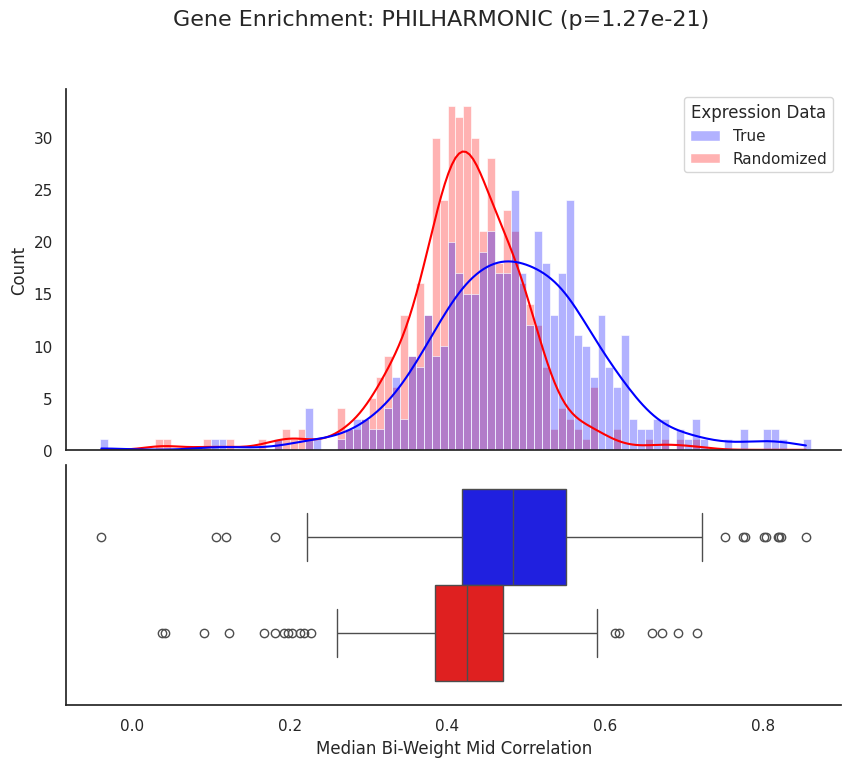

In [61]:
sns.set_palette("colorblind")
sns.set_theme(style="white", palette="pastel", font_scale=1)

tstat_rand, p_rand = ttest_rel(
    cluster_corr_df["True"], cluster_corr_df["Randomized"], alternative="greater"
)

plot_df = cluster_corr_df.melt("key").rename(
    {"value": "Median Bi-Weight Mid Correlation", "variable": "Expression Data"}, axis=1
)

# Create figure and gridspec
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 2], hspace=0.05)

# Create top subplot for histogram
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

sns.histplot(
    data=plot_df,
    x="Median Bi-Weight Mid Correlation",
    hue="Expression Data",
    alpha=0.3,
    kde=True,
    bins=np.arange(-0.1, 1.05, 0.01),
    palette=["blue", "red"],
    common_norm=False,
    ec="white",
    ax=ax0,
)

sns.boxplot(
    data=cluster_corr_df.melt("key"),
    x="value",
    hue="variable",
    palette=["blue", "red"],
    ax=ax1,
)

ax0.set_xlabel("")  # Remove x-label from top plot
ax1.set_xlabel("Median Bi-Weight Mid Correlation")  # Add x-label to bottom plot
ax0.set_xticklabels([])  # Remove x-ticks from top plot


ax0.set_xlim(ax1.get_xlim())  # Align the x-axis of both subplots
ax1.get_legend().remove()  # Remove legend from bottom plot

plt.suptitle(f"Gene Enrichment: PHILHARMONIC (p={p_rand:.3})", fontsize=16)

# Show the plot
sns.despine()
plt.savefig(IMG_DIR / "gexp_enrichment_combined.svg", bbox_inches="tight", dpi=300)
plt.show()

---

## Export Differential Expression for Cytoscape

In [14]:
philharmonic_prots = set.union(
    *[set(c["members"]) for c in cluster_dict.values()]
).intersection(deg_df.index)
prot_deg_cytoscape_table_df = deg_df.loc[
    list(philharmonic_prots),
    [
        "log2FoldChange_Heat_control",
        "log2FoldChange_Antibiotics_control",
        "log2FoldChange_Antibiotics.Heat_control",
    ],
]

logger.info(f"Writing {len(philharmonic_prots)} entries to {prot_deg_cytoscape_table}")
prot_deg_cytoscape_table_df.to_csv(prot_deg_cytoscape_table, sep="\t")

2024-10-21 10:56:50.134 | INFO     | __main__:<module>:13 - Writing 4235 entries to /mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_proteins.deg.tsv


In [15]:
conditions = ["Heat_control", "Antibiotics_control", "Antibiotics.Heat_control"]
p_thresh = 0.05

cluster_de_df = []

for k, cl in tqdm(cluster_dict.items(), total=len(cluster_dict)):
    cluster_members = list(set(cl["members"]).intersection(deg_df.index))
    diffexp_df = deg_df.loc[cluster_members]
    cluster_row = [k]

    for cond in conditions:
        # log2FoldChange
        if len(diffexp_df):
            cluster_row.append(np.mean(diffexp_df[f"log2FoldChange_{cond}"]))
        else:
            cluster_row.append(np.nan)
        # padj
        cluster_row.append(np.sum(diffexp_df[f"padj_{cond}"] < p_thresh))
        # DE_Up
        cluster_row.append(np.sum(diffexp_df[f"DE_{cond}"] == "Upregulated"))
        # DE_Down
        cluster_row.append(np.sum(diffexp_df[f"DE_{cond}"] == "Downregulated"))
    cluster_de_df.append(cluster_row)

cluster_de_df = pd.DataFrame(cluster_de_df)
cluster_de_df.columns = ["key"] + [
    f"{j}_{i}"
    for i, j in product(conditions, ["log2FoldChange", "padj", "DE_Up", "DE_Down"])
]
cluster_de_df = cluster_de_df.set_index("key")

100%|██████████| 468/468 [00:00<00:00, 786.54it/s]


In [16]:
cluster_de_df.head()
cluster_de_df.to_csv(clust_deg_cytoscape_table, sep="\t")
logger.info(f"Writing {len(cluster_de_df)} entries to {clust_deg_cytoscape_table}")

2024-10-21 10:56:50.769 | INFO     | __main__:<module>:3 - Writing 468 entries to /mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/20240917-pdamAll-phil_v0.3.0_clusters.deg.tsv


## Heat-Specific DE

In [36]:
llm_path = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0/pdam_clusters.llm.json"
llm_clusters = load_cluster_json(llm_path)

In [49]:
import re

keywords = ["heat", "cold", "temperature", "thermal", "thermo", "cool", "warm"]

# create a regex that matches any of the keywords
pattern = re.compile("|".join(keywords), re.IGNORECASE)

In [126]:
# get list of cluster IDs where human_readable descriptions match the pattern
filtered_clusters = [
    k
    for k, v in llm_clusters.items()
    # if pattern.search(" ".join([v["human_readable"], v["llm_name"], v["llm_explanation"]]))
    if pattern.search(" ".join([v["llm_name"], v["llm_explanation"]]))
]
non_filtered = [k for k in llm_clusters.keys() if k not in filtered_clusters]
logger.info(f"Filtered {len(filtered_clusters)} clusters with keywords: {keywords}")

2025-05-06 09:52:02.252 | INFO     | __main__:<module>:9 - Filtered 30 clusters with keywords: ['heat', 'cold', 'temperature', 'thermal', 'thermo', 'cool', 'warm']


In [134]:
def get_from_deg(deg_df, cluster_dict, key, columns):
    """
    Get the values from the deg_df for the given proteins and columns.
    """
    proteins = cluster_dict[key]["members"]
    p_intersection = list(set(proteins).intersection(deg_df.index))
    return deg_df.loc[p_intersection, columns]


def print_cluster(cluster_dict, key):
    print(cluster_dict[key]["llm_name"])
    print(cluster_dict[key]["human_readable"])
    # print(cluster_dict[key]["llm_explanation"])

In [183]:
i = 18
print_cluster(llm_clusters, non_filtered[i])
get_from_deg(
    deg_df,
    llm_clusters,
    non_filtered[i],
    [
        "log2FoldChange_Heat_control",
        "padj_Heat_control",
        "DE_Heat_control",
        "Gene_Info",
    ],
)

Cerebellar Development and Cell Cycle Regulation
Cluster Name: Cerebellar Development and Cell Cycle Regulation
Cluster of 28 proteins [pdam_00018973-RA, pdam_00011383-RA, pdam_00023698-RA, ...] (hash 744582039424568290)
0 proteins re-added by ReCIPE (degree, 0.75)
Edges: 37
Triangles: 16
Max Degree: 18
Top Terms:
		GO:0021697 - <cerebellar cortex formation> (25)
		GO:0045736 - <negative regulation of cyclin-dependent protein serine/threonine kinase activity> (25)
		GO:2001275 - <obsolete positive regulation of glucose import in response to insulin stimulus> (25)
		GO:0008286 - <insulin receptor signaling pathway> (25)
		GO:0034501 - <protein localization to kinetochore> (25)
		GO:0000082 - <G1/S transition of mitotic cell cycle> (25)
		GO:0060020 - <Bergmann glial cell differentiation> (25)
		GO:0008285 - <negative regulation of cell population proliferation> (25)
		GO:0050852 - <T cell receptor signaling pathway> (25)
		GO:0048679 - <regulation of axon regeneration> (25)
LLM Explanat

,log2FoldChange_Heat_control,padj_Heat_control,DE_Heat_control,Gene_Info
ID,,,,
pdam_00023699-RA,-0.324394,0.287748,NaN,tie1: Tyrosine-protein kinase receptor Tie-1 ...
pdam_00025104-RA,-0.303708,0.380263,NaN,PTPRM: Receptor-type tyrosine-protein phospha...
pdam_00014942-RA,-0.693303,0.183861,NaN,RET: Proto-oncogene tyrosine-protein kinase r...
pdam_00014059-RA,-0.162099,0.446473,NaN,KSR2: Kinase suppressor of Ras 2 (Homo sapiens)
pdam_00011383-RA,0.019749,0.966202,NaN,Dusp19: Dual specificity protein phosphatase ...
pdam_00021587-RA,0.071925,0.771906,NaN,CAMKK2: Calcium/calmodulin-dependent protein ...
pdam_00022468-RA,-0.202303,0.447325,NaN,Eif2ak4: eIF-2-alpha kinase GCN2 (Mus musculus)
pdam_00009015-RA,-0.126850,0.754690,NaN,Aatk: Serine/threonine-protein kinase LMTK1 (...
pdam_00018186-RA,-0.101587,0.576695,NaN,Tgfbr1: TGF-beta receptor type-1 (Rattus norv...


In [ ]:
deg_df